# Workspace \#4: ``echo.py``

In [1]:
# %load firstcell.py
# autoreloading for imported modules
%load_ext autoreload
%autoreload 2

# getting future division
from __future__ import division

# numpy
import numpy as np
from numpy import pi, sqrt, log, log10, power, exp

#scipy
from scipy.interpolate import interp1d

# matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import rc
from matplotlib.lines import Line2D

# other
import os
from tqdm import tqdm

# matplotlib style
%matplotlib inline

%config InlineBackend.figure_format = "retina"
rcParams['figure.figsize'] = (13, 8)
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['New Times Roman']
rc('text', usetex=True)

# current directory
current_dir = os.getcwd()

In [2]:
from random import random

import sys
sys.path.insert(0, '../')

import constants as ct
import particle as pt
import astro as ap
import echo as ec

/home/buenabad/anaconda2/lib/python2.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/home/buenabad/anaconda2/lib/python2.7/site-packages/healpy/fitsfunc.py:403: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


In [3]:
# The contents of echo.py
dir(ec)

['Snu_echo',
 'Snu_source',
 'Tbg_408_antipodal',
 'Tbg_408_avg',
 '__builtins__',
 '__doc__',
 '__file__',
 '__name__',
 '__package__',
 'ap',
 'axion_pref',
 'check_axion',
 'check_data',
 'check_source',
 'ct',
 'dSnu_echo',
 'division',
 'echo_ad_fn',
 'echo_an',
 'echo_an_sup',
 'echo_free_fn',
 'echo_tot_fn',
 'erf',
 'exp',
 'ga_reach',
 'interp1d',
 'interp_fn',
 'lambertw',
 'log',
 'log10',
 'ma_ga_bound',
 'noise',
 'np',
 'nu_array_default',
 'os',
 'pi',
 'power',
 'pref',
 'pt',
 'quad',
 'signal',
 'sn_ratio',
 'snr_fn',
 'sqrt',
 'trapz']

Checking the line of sight integrand

/home/buenabad/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


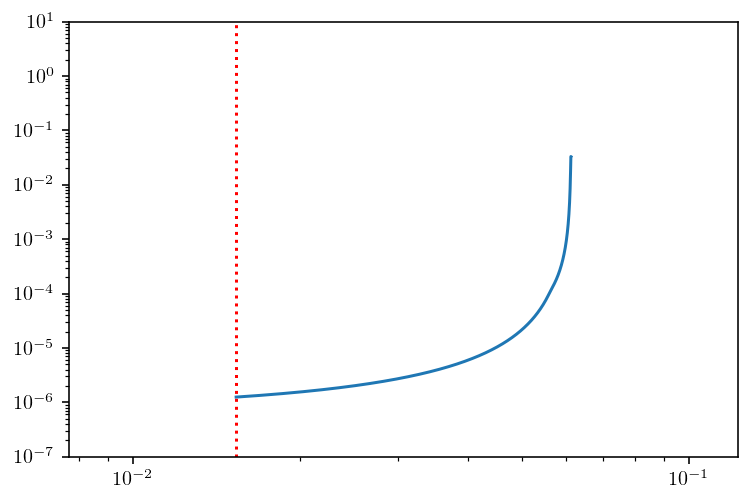

In [4]:
output = {}

D = 3.4 # [kpc] Cas A
A = 4.*pi*(D*ct._kpc_over_cm_)**2. # [cm^2] area
SnuCasA = 2723 # [Jy] Cas A

LumCasA = (SnuCasA*ct._Jy_over_cgs_irrad_)*A

source_input = {'longitude':111.734745, # Cas A
                'latitude':-02.129570, # Cas A
                'distance':D, # Cas A
                'size':1.e-6,
                't_age':300., # Cas A
                'alpha':0.77,
                'nu_pivot':1.,
                'gamma':2.03, # Cas A experiment
                'model':'eff', 'L_today':LumCasA, 'L_peak':1.e30,
                't_peak':100.
               }

axion_input = {'ma':pt.ma_from_nu(1.),
               'ga':1.e-10
              }
axion_prefactor = ec.axion_pref(axion_input['ma'], axion_input['ga'])

data = {'deltaE_over_E':1.e-3
       }

t_arr = np.logspace(log10(1./365), log10(source_input['t_age']), 1001)

# computing source
ec.Snu_source(t_arr, 1., source_input, output=output)
tArr, nu, SnuArr = output['source_t-nu-Snu']
Snu_fn = ec.interp_fn(np.vstack((tArr, SnuArr)).T)

theta_echo = pi - ap.theta_gal_ctr(source_input['longitude'], source_input['latitude'], output_radians=True)

t_age = source_input['t_age']
tmin = (source_input['t_peak']/365.)
xmax = min([100., (t_age - tmin)/(2.*ct._kpc_over_lightyear_)])
xmin = ct._au_over_kpc_

# adding extra years
t_extra_old = 100.
x_offset = t_extra_old/(2.*ct._kpc_over_lightyear_)

tage_extended = t_age + t_extra_old
xmax += x_offset
xmin += x_offset

t_lo = tage_extended - 2.*(xmax*ct._kpc_over_lightyear_) # lowest time probed by l.o.s.
t_hi = tage_extended - 2.*(xmin*ct._kpc_over_lightyear_) # highest time probed by l.o.s.
t_arr2 = np.logspace(log10(t_lo), log10(t_hi), 5001) # array of times
xArr = ((t_age - t_arr2)/(2.*ct._kpc_over_lightyear_))[::-1]
xArr += x_offset

dSArr = ec.dSnu_echo(x=xArr,
                     theta=theta_echo,
                     tobs=tage_extended,
                     axion_prefactor=axion_prefactor,
                     Snu_fn=Snu_fn,
                     rho=ap.rho_MW,
                     delE_over_E=data['deltaE_over_E'])

fig_num = int(random()*100)
plt.figure(fig_num)
plt.loglog(xArr, dSArr)
plt.xlim(xmin/2., xmax*2.);
plt.ylim(1.e-7, 10.);
# plt.axvline(ct._au_over_kpc_, c='k', ls=':')
plt.axvline(xmin, c='r', ls=':')

In [5]:
help(ec.Snu_echo)

Help on function Snu_echo in module echo:

Snu_echo(source_input, axion_input, data, recycle_output=(False, None), tmin_default=None, Nt=1001, xmin=4.84810158797031e-09, xmax_default=100.0, use_quad=False, lin_space=False, Nint=50001, t_extra_old=0.0)
    Computes the spectral irradiance (flux density) [Jy] of the echo. Saves to output.
    
    Parameters
    ----------
    source_input : dictionary with source input parameters
    axion_input : dictionary with axion parameters
    data : dictionary with environmental, experimental, and observational data
    recycle_output : whether we recycle a previous computation; and the location where it is stored (default: (False, None))
    tmin_default : the default cutoff minimum time [years] (i.e. the youngest age) of the SNR we will consider (default: None)
    Nt : number of time points over which we interpolate the source's Snu
    xmin : the closest integration distance [kpc] we will consider (default: 1 AU)
    xmax_default : the defau

Computing spectal irradiance echo, comparing different methods

In [6]:
data.update({'verbose':3})
ec.Snu_echo(source_input, axion_input, data,
            recycle_output=(True, output),
            use_quad=True)

print 'next'
ec.Snu_echo(source_input, axion_input, data,
            recycle_output=(False, None),
            use_quad=True)

Snu_echo = 7.62e-06, error=5.79e-09

next
Snu_echo = 7.62e-06, error=6.86e-09



7.619949297664744e-06

In [7]:
output

{'echo_Snu': 7.619924347511481e-06,
 'source_t-nu-Snu': (array([2.73972603e-03, 2.77170209e-03, 2.80405136e-03, ...,
         2.93117958e+02, 2.96539015e+02, 3.00000000e+02]),
  1.0,
  array([2.32484679e-54, 1.28937299e-53, 7.00958861e-53, ...,
         2.85435288e+03, 2.78790295e+03, 2.72300000e+03]))}

In [8]:
# varying the various parameters of the ec.Snu_echo function:

print 'default:', ec.Snu_echo(source_input, axion_input, data,
                              recycle_output=(True, output),
                              tmin_default=None, use_quad=False,
                              lin_space=True, Nint=50001)

# no recylcing:
print 'no recylcing:', ec.Snu_echo(source_input, axion_input, data,
                                   recycle_output=(False, None),
                                   tmin_default=None, use_quad=False,
                                   lin_space=True, Nint=50001)

# less fine grid
print 'coarser grid:', ec.Snu_echo(source_input, axion_input, data,
                                   recycle_output=(True, output),
                                   tmin_default=None, use_quad=False,
                                   lin_space=True, Nint=5001)

# smaller tmin (looking deeper into the history of the SN)
print 'smaller tmin:', ec.Snu_echo(source_input, axion_input, data,
                                   recycle_output=(True, output),
                                   tmin_default=(1./365.), use_quad=False,
                                   lin_space=True, Nint=50001)

ec.Snu_echo(source_input, axion_input, data,
            recycle_output=(True, output),
            tmin_default=None, use_quad=False,
            lin_space=True, Nint=50001)

pass

default: 7.6199155830297766e-06
no recylcing: 7.619937487458246e-06
coarser grid: 7.6199452692853886e-06
smaller tmin: 8.370711664831015e-06


### Example: full echo computation

In [9]:
D = 3.4 # [kpc] Cas A
# D = 0.5
A = 4.*pi*(D*ct._kpc_over_cm_)**2. # [cm^2] area
SnuCasA = 2723 # [Jy] Cas A

LumCasA = (SnuCasA*ct._Jy_over_cgs_irrad_)*A

source_input = {'longitude':111.734745, # Cas A
                'latitude':-02.129570, # Cas A
                'distance':D, # Cas A
                'size':1.e-6,
                't_age':300., # Cas A
                'alpha':0.77,
                'nu_pivot':1.,
                'gamma':2.03, # Cas A experiment
                'model':'eff', 'L_today':LumCasA, 'L_peak':1.e30,
                't_peak':100.
               }

ma_ref, ga_ref = 3.e-6, 1.e-10
axion_input = {'ma':ma_ref,
               'ga':ga_ref
              }
nu_ma = pt.nu_from_ma(ma_ref)

data = {'deltaE_over_E':1.e-3,
        'f_Delta':0.721,
        'exper':'SKA',
        'total_observing_time':100.,
        'average':False,
        'verbose':0
       }

t_peak = source_input['t_peak']
t_age = source_input['t_age']

Snu_echo_kwargs = {'tmin_default':None,
                   'Nt':10001,
                   'xmin':ct._au_over_kpc_,
                   'xmax_default':100.,
                   'use_quad':False,
                   'lin_space':False,
                   'Nint':int(30*(t_age)+1),
                   't_extra_old':0.}
t_arr = np.logspace(log10(t_peak/365.), log10(t_age), 5001)

output = {}
print 'Snu of source:', ec.Snu_source(t_arr, nu_ma, source_input,
                  output=output)

Snu_echo = ec.Snu_echo(source_input, axion_input, data,
                  recycle_output=(True, output),
                  **Snu_echo_kwargs)

print 'Snu_echo', Snu_echo

result = ec.signal(source_input, axion_input, data,
                recycle_output=(True, output),
                **Snu_echo_kwargs)
_, _, _, _, Psignal = result
print 'signal computation result (nu, delnu, snu_echo, s_echo, power): ', result
print 'signal power', Psignal

Snu of source: [1.57860975e+08 1.57860743e+08 1.57860048e+08 ... 5.97950901e+03
 5.96254298e+03 5.94562508e+03]
Snu_echo 4.587291965631942e-05
signal computation result (nu, delnu, snu_echo, s_echo, power):  (0.36269837676165373, 0.0003626983767616537, 4.587291965631942e-05, 2.6615238451504673e-35, 3.9425993844195355e-16)
signal power 3.9425993844195355e-16


In [10]:
print '(nu, delnu, tbg_408, t_noise, noise power):', ec.noise(source_input, axion_input, data, recycle_output=(True, output))

(nu, delnu, tbg_408, t_noise, noise power): (0.36269837676165373, 0.0003626983767616537, 69.87706756591797, 120.06135212563396, 3.426757033845086e-17)


In [11]:
help(ec.sn_ratio)

Help on function sn_ratio in module echo:

sn_ratio(signal_power, noise_power, output=None, verbose=0)
    Returns the signal-to-noise ratio.
    
    Parameters
    ----------
    signal_power : power of signal [eV^2]
    noise_power : power of noise [eV^2]
    output : output dictionary (default: None)
    verbose : verbosity (default: 0)



In [12]:
signal_power = output['signal_power']
noise_power = output['noise_power']

print 'S/N:', ec.sn_ratio(signal_power, noise_power, output=output)

S/N: 11.505336811100477


In [13]:
print signal_power, Psignal, noise_power
print output['S/N']

3.9425993844195355e-16 3.9425993844195355e-16 3.426757033845086e-17
11.505336811100477


In [14]:
help(ap.SKA_specs)

Help on function SKA_specs in module astro:

SKA_specs(nu, exper_mode)
    Returns the specifications (area [m^2], window, receiver noise brightness temperature [K]) of the SKA experiment mode, for the given frequency [GHz].
    
    Parameters
    ----------
    nu : frequency [GHz]
    exper_mode : mode in which the experiment is working



In [15]:
# yet another way to compute S/N ratio:

delnu = nu_ma * data['deltaE_over_E']

exper_mode = ap.SKA_exper_nu(nu)
_, _, Tr = ap.SKA_specs(nu_ma, exper_mode)

Tbg_408 = ap.bg_408_temp(l=(180.+source_input['longitude']), b=-source_input['latitude'], size=source_input['size'], average=False)
Tnoise = ap.T_noise(nu_ma, Tbg_at_408=Tbg_408, Tr=Tr)
Pnoise = ap.P_noise(Tnoise, delnu, 100.)

print Tbg_408, Tnoise, Pnoise
print Psignal/Pnoise

69.87706756591797 120.06135212563396 3.426757033845086e-17
11.505336811100477


In [16]:
help(ec.snr_fn)

Help on function snr_fn in module echo:

snr_fn(Secho, nu, delta_nu, Tbg_408=34.3979975598877, fDelta=0.721, tobs=100.0)
    Simpler signal-to-noise ratio formula.
    
    Parameters
    ----------
    Secho : echo flux density (spectral irradiance) [Jy]
    nu : signal frequency [GHz]
    delta_nu : the bandwidth of the detector [GHz]
    Tbg_408 : the MW background at 408 MHz [K] (default: full sky average)
    fDelta : the fraction of signal falling withing the bandwidth (default: 0.721)
    tobs : the total observation time [hours] (default: 100)



Comparing with analytic computation:

In [17]:
Lpk, tpk, dist, L0, tage, gam = source_input['L_peak'], source_input['t_peak'], source_input['distance'], source_input['L_today'], source_input['t_age'], source_input['gamma']

# frequency factor
fac = (nu_ma/source_input['nu_pivot'])**(-source_input['alpha'])
# frequency correction
Lpk *= fac
L0 *= fac
# spectral irradiance today
S0 = (L0/ct._Jy_over_cgs_irrad_)/(4.*pi*(dist*ct._kpc_over_cm_)**2.)

ftpk = (tpk/365.)/tage # fractional peak time
sup = L0/Lpk # fractional suppression
ftt = ap.ftt(gam, ftpk, L0/Lpk) # fractional transition time

print 'ftpk:', ftpk, '\n', 'ftt:', ftt

# def echo_an_sup(ma, ga, Lpk, dist, S0, t_age, gamma, tpk, deltaE_over_E=1.e-3)

Snu_echo_an = ec.echo_an_sup(ma_ref, ga_ref,
                             Lpk, dist, S0,
                             tage, gam, tpk,
                             deltaE_over_E=data['deltaE_over_E'])

print 'numeric:', ec.snr_fn(Snu_echo, nu_ma, nu_ma*data['deltaE_over_E'], Tbg_408)
print 'analytic:', ec.snr_fn(Snu_echo_an, nu_ma, nu_ma*data['deltaE_over_E'], Tbg_408)

ftpk: 0.000913242009132 
ftt: 0.10864171928242404
numeric: 11.505336811100477
analytic: 11.468656688826005
